# Final Main Implementation v.6

> This is a the main CNN implementation to recognize images of sign language digits.

In [112]:
# libraries:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### Defining the CNN model

In [ ]:
def build_cnn(input_shape=(64, 64, 1), num_classes=10):
    model = models.Sequential([
        # Convolutional Layers
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.1),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.1),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [121]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

### Loading and preprocessing the data

In [114]:
# Load images and labels
X = np.load('data/X.npy').astype('float32')
y = np.load('data/Y.npy')

In [115]:
# Add channel dimension (grayscale)
X = X.reshape(-1, 64, 64, 1)  # New shape: (2062, 64, 64, 1)

In [ ]:
# Spliting the data into train & validation (80%) / testing (%20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [117]:
# Convert one-hot labels to integers 
y_trainval = np.argmax(y_trainval, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
# Initilizing the k-folds CV (this was for choosing the best model while experimenting)
k = 10  # chosen to be the most optimal
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
# Data Augmentation: helps increase the diversity of training data by applying random transformations like rotation and zoom
datagen = ImageDataGenerator(
    rotation_range=15,           # Randomly rotate images in the range (degrees)
    zoom_range=0.1,              # Randomly zoom images
    width_shift_range=0.1,       # Randomly shift images horizontally
    height_shift_range=0.1,      # Randomly shift images vertically
    cval=0                       # Fill value for empty areas
)

### CNN Implementation with k-fold CV To find the best model while experimenting (Disregard these values for the final report)

In [120]:
# Lists to store history from each fold
accuracies = []
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

In [ ]:
# K-fold CV:
for train_index, val_index in kf.split(X_trainval):
    
    # Split data into training and validation
    X_train, X_val = X_trainval[train_index], X_trainval[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

   # Compute augmentations
    datagen.fit(X_train)

    # Create and train model 
    model = build_cnn() 
    history = model.fit(X_train, y_train, 
                       validation_data=(X_val, y_val),
                       epochs=30, batch_size=32,
                       callbacks=callbacks)
    
    # Evaluate and store accuracy
    val_acc = model.evaluate(X_val, y_val)[1]
    accuracies.append(val_acc)

    # Store metrics (this is for graphing)
    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])


Epoch 1/30


/Users/anthamorious/Library/Mobile Documents/com~apple~CloudDocs/University/University of Houston/Semesters/🎓 Spring 2025/🌹 COSC 4337 - Data Science II/Project/Final report/COSC4337-project-main/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3880 - loss: 3.3854 - val_accuracy: 0.0848 - val_loss: 3.8594 - learning_rate: 0.0010
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7821 - loss: 1.7906 - val_accuracy: 0.0848 - val_loss: 4.6567 - learning_rate: 0.0010
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8601 - loss: 1.4751 - val_accuracy: 0.0848 - val_loss: 3.6519 - learning_rate: 0.0010
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9204 - loss: 1.1597 - val_accuracy: 0.2061 - val_loss: 3.6369 - learning_rate: 0.0010
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9430 - loss: 0.9398 - val_accuracy: 0.1030 - val_loss: 3.3612 - learning_rate: 0.0010
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9482 - loss: 0.8215 - val_accuracy: 0.3576 - val_loss: 2.4783 - learning_rate: 0.0010
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9491 - loss: 0.7332 - val_accuracy: 0.26

### Viewing CNN Statistics Accuracy & Loss for K-fold (also disregard for final report)

In [125]:
def plot_avg_accuracy(train_acc, val_acc):
    avg_train_acc = np.mean(train_acc, axis=0)
    avg_val_acc = np.mean(val_acc, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_acc, label='Training Accuracy')
    plt.plot(avg_val_acc, label='Validation Accuracy')
    plt.title('Average Training & Validation Accuracy Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [126]:
def plot_avg_loss(train_loss, val_loss):
    avg_train_loss = np.mean(train_loss, axis=0)
    avg_val_loss = np.mean(val_loss, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(avg_train_loss, label='Training Loss')
    plt.plot(avg_val_loss, label='Validation Loss')
    plt.title('Average Training & Validation Loss Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [127]:
def plot_individual_folds(metric, title, ylabel):
    plt.figure(figsize=(10, 5))
    for i, fold_metric in enumerate(metric):
        plt.plot(fold_metric, label=f'Fold {i+1}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [128]:
def plot_overlaid_folds(train_metric, val_metric, metric_name):
    plt.figure(figsize=(12, 6))
    
    # Plot all training metrics
    for i, fold_metric in enumerate(train_metric):
        plt.plot(fold_metric, color='blue', alpha=0.2, linestyle='-')
    
    # Plot all validation metrics
    for i, fold_metric in enumerate(val_metric):
        plt.plot(fold_metric, color='orange', alpha=0.2, linestyle='-')
    
    # Plot averages
    plt.plot(np.mean(train_metric, axis=0), color='blue', 
             linewidth=2, label='Avg Training')
    plt.plot(np.mean(val_metric, axis=0), color='orange', 
             linewidth=2, label='Avg Validation')
    
    plt.title(f'Training & Validation {metric_name} Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
print(f"Average validation accuracy: {np.mean(accuracies):.2%}")

Average validation accuracy: 96.72%


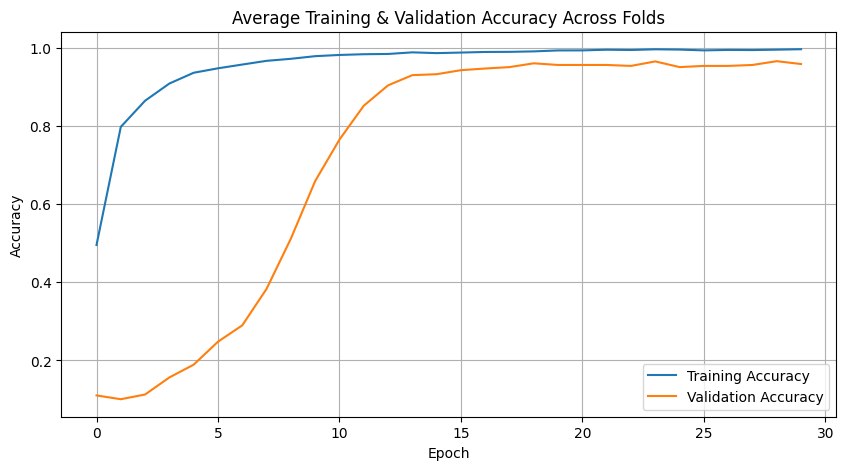

In [130]:
# Plotting average accuracy
plot_avg_accuracy(all_train_acc, all_val_acc)

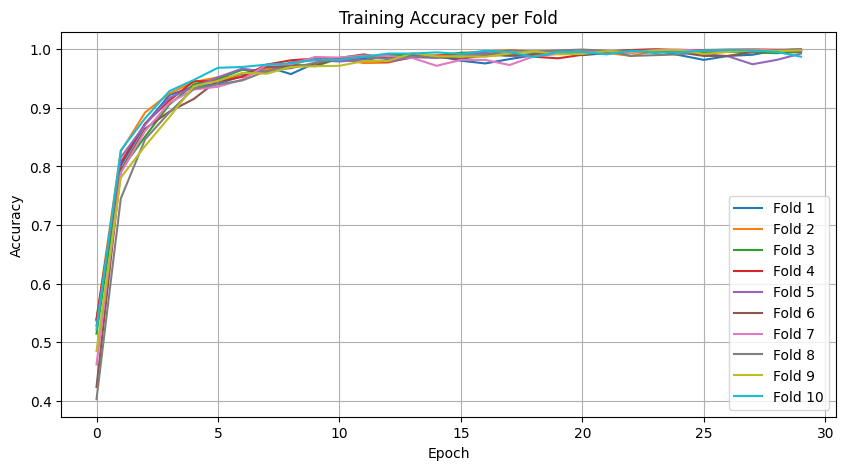

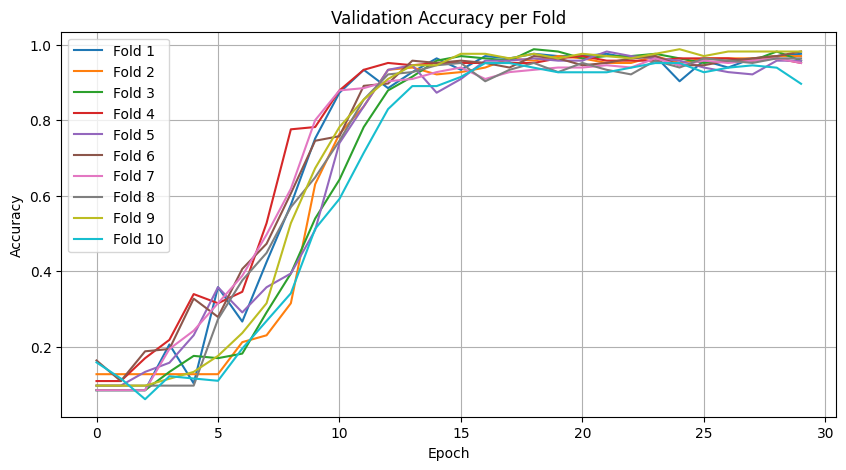

In [131]:
# Plot individual folds accuracy
plot_individual_folds(all_train_acc, 'Training Accuracy per Fold', 'Accuracy')
plot_individual_folds(all_val_acc, 'Validation Accuracy per Fold', 'Accuracy')

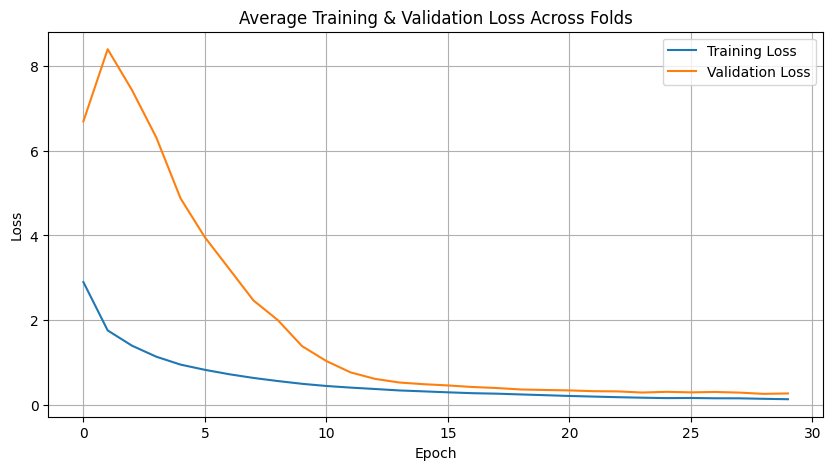

In [132]:
# Plotting average loss
plot_avg_loss(all_train_loss, all_val_loss)

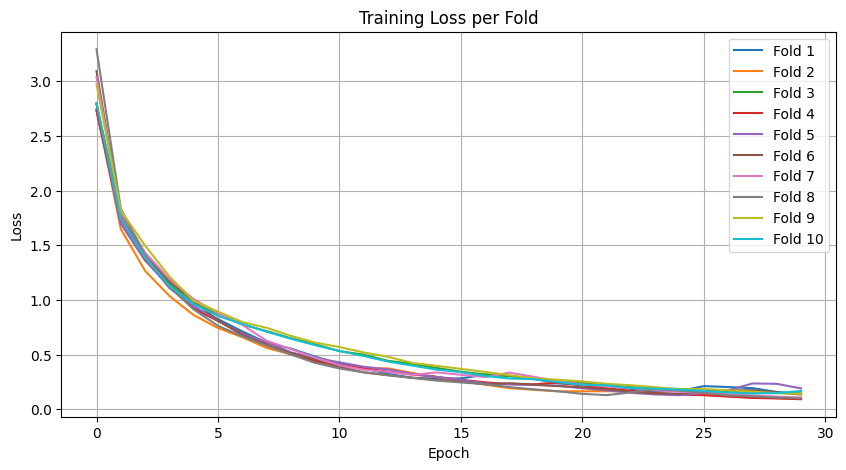

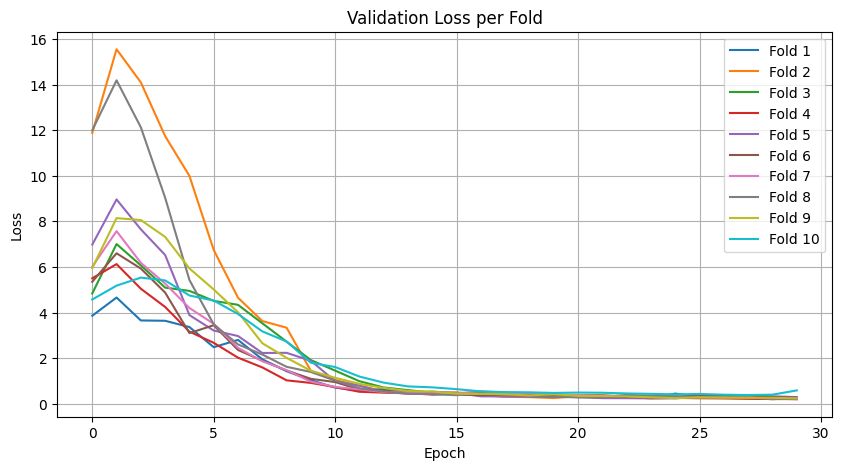

In [133]:
# Plot individual folds loss
plot_individual_folds(all_train_loss, 'Training Loss per Fold', 'Loss')
plot_individual_folds(all_val_loss, 'Validation Loss per Fold', 'Loss')

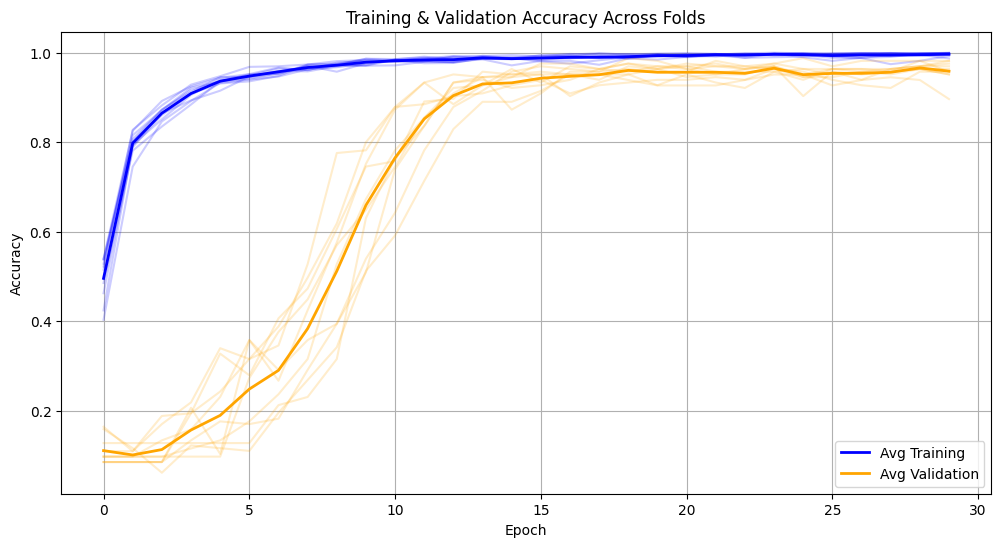

In [134]:
plot_overlaid_folds(all_train_acc, all_val_acc, 'Accuracy')

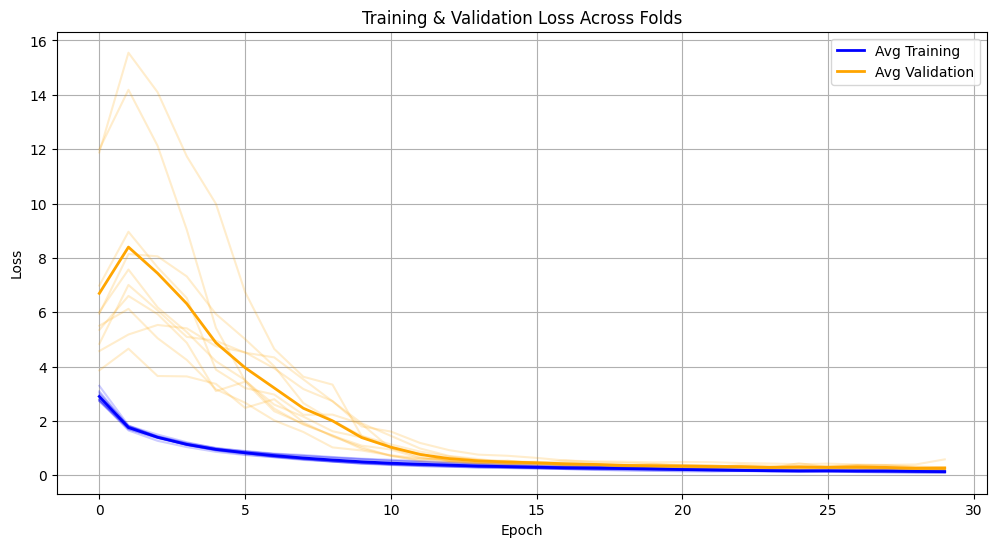

In [135]:
plot_overlaid_folds(all_train_loss, all_val_loss, 'Loss')

### Properly training and testing the model

In [143]:
final_model = build_cnn()
model.summary()

/Users/anthamorious/Library/Mobile Documents/com~apple~CloudDocs/University/University of Houston/Semesters/🎓 Spring 2025/🌹 COSC 4337 - Data Science II/Project/Final report/COSC4337-project-main/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,166,688 (4.45 MB)

 Trainable params: 388,746 (1.48 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 777,494 (2.97 MB)

In [ ]:
# Training the model on all of the training and validation set
final_history = final_model.fit(X_trainval, y_trainval,
                 epochs=30,
                 batch_size=32,
                 validation_data=(X_test, y_test),
                 callbacks=callbacks) 

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.3357 - loss: 3.8710 - val_accuracy: 0.0993 - val_loss: 9.3221 - learning_rate: 0.0010
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.7966 - loss: 1.7745 - val_accuracy: 0.0993 - val_loss: 12.1990 - learning_rate: 0.0010
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8630 - loss: 1.4396 - val_accuracy: 0.0993 - val_loss: 11.9451 - learning_rate: 0.0010
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9190 - loss: 1.1213 - val_accuracy: 0.0993 - val_loss: 9.5161 - learning_rate: 0.0010
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9469 - loss: 0.9165 - val_accuracy: 0.0993 - val_loss: 6.8818 - learning_rate: 5.0000e-04
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9660 - loss: 0.8344 - val_accuracy: 0.1332 - val_loss: 5.5593 - learning_rate: 5.0000e-04
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9683 - loss: 0.7436

In [145]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.2%}")

13/13 - 0s - 14ms/step - accuracy: 0.9516 - loss: 0.2897
Test Accuracy: 95.16%


In [146]:
# Now generate your reports
y_pred = final_model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        41
           1       1.00      0.95      0.97        41
           2       0.95      1.00      0.98        41
           3       0.95      0.95      0.95        41
           4       0.95      0.95      0.95        42
           5       1.00      0.98      0.99        42
           6       0.98      0.98      0.98        41
           7       0.93      0.93      0.93        41
           8       0.93      0.93      0.93        42
           9       0.95      0.98      0.96        41

    accuracy                           0.96       413
   macro avg       0.96      0.96      0.96       413
weighted avg       0.96      0.96      0.96       413



In [ ]:
#model.save('sign_language_digits.h5')  # Save the trained model